## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.regularizers import l1
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],l1_ratio=1e-4):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [16]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 8s 150us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.4626 - accuracy: 0.0987 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 46/50
50000/50000 [==============================] - 5s 97us/step - loss: 2.7895 - accuracy: 0.6202 - val_loss: 3.0511 - val_accuracy: 0.5271
Epoch 47/50
50000/50000 [==============================] - 5s 97us/step - loss: 2.7489 - accuracy: 0.6223 - val_loss: 3.0466 - val_accuracy: 0.5119
Epoch 48/50
50000/50000 [==============================] - 5s 98us/step - loss: 2.7076 - accuracy: 0.6267 - val_loss: 2.9779 - val_accuracy: 0.5294
Epoch 49/50
50000/50000 [==============================] - 5s 98us/step - loss: 2.6727 - accuracy: 0.6273 - val_loss: 2.9608 - val_accuracy: 0.5297
Epoch 50/50
50000/50000 [==============================] - 5s 97us/step - loss: 2.6310 - accuracy: 0.6315 - val_loss: 2.9082 - val_accuracy: 0.5323
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
________

50000/50000 [==============================] - 5s 102us/step - loss: 0.9795 - accuracy: 0.6547 - val_loss: 1.3676 - val_accuracy: 0.5224
Epoch 44/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.9636 - accuracy: 0.6610 - val_loss: 1.4025 - val_accuracy: 0.5223
Epoch 45/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.9553 - accuracy: 0.6625 - val_loss: 1.3803 - val_accuracy: 0.5276
Epoch 46/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.9413 - accuracy: 0.6674 - val_loss: 1.3850 - val_accuracy: 0.5298
Epoch 47/50
50000/50000 [==============================] - 5s 106us/step - loss: 0.9301 - accuracy: 0.6734 - val_loss: 1.3553 - val_accuracy: 0.5316
Epoch 48/50
50000/50000 [==============================] - 8s 157us/step - loss: 0.9173 - accuracy: 0.6764 - val_loss: 1.4141 - val_accuracy: 0.5234
Epoch 49/50
50000/50000 [==============================] - 8s 160us/step - loss: 0.9099 - accuracy: 0.6814 - val_loss:

Epoch 41/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.9829 - accuracy: 0.6533 - val_loss: 1.4002 - val_accuracy: 0.5159
Epoch 42/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.9657 - accuracy: 0.6602 - val_loss: 1.3532 - val_accuracy: 0.5222
Epoch 43/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.9536 - accuracy: 0.6646 - val_loss: 1.3808 - val_accuracy: 0.5219
Epoch 44/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.9430 - accuracy: 0.6706 - val_loss: 1.5734 - val_accuracy: 0.4817
Epoch 45/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.9331 - accuracy: 0.6734 - val_loss: 1.3794 - val_accuracy: 0.5221
Epoch 46/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.9198 - accuracy: 0.6744 - val_loss: 1.4613 - val_accuracy: 0.5050
Epoch 47/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.9023 - accuracy: 0.6860 - val

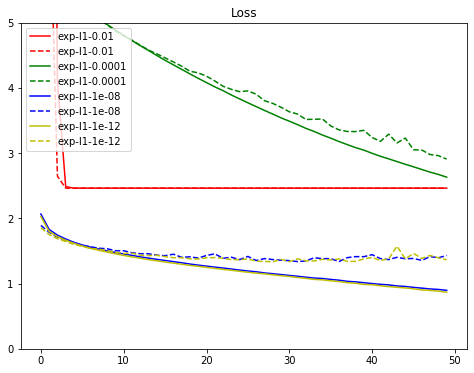

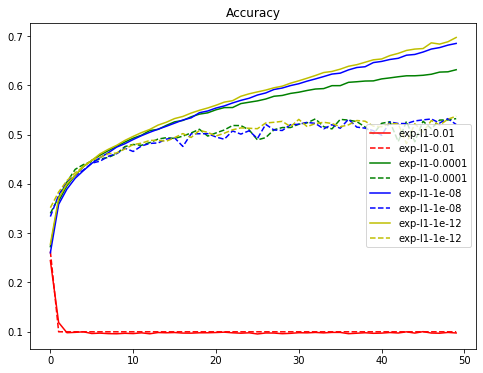

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()